<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Business-case" data-toc-modified-id="Business-case-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Business case</a></span></li><li><span><a href="#Assumptions" data-toc-modified-id="Assumptions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Assumptions</a></span></li><li><span><a href="#Approach" data-toc-modified-id="Approach-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Approach</a></span><ul class="toc-item"><li><span><a href="#Building-customer-insight" data-toc-modified-id="Building-customer-insight-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Building customer insight</a></span></li><li><span><a href="#Building-experimentation-framework" data-toc-modified-id="Building-experimentation-framework-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Building experimentation framework</a></span></li></ul></li><li><span><a href="#Data-preperation" data-toc-modified-id="Data-preperation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data preperation</a></span><ul class="toc-item"><li><span><a href="#Lowercasing" data-toc-modified-id="Lowercasing-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Lowercasing</a></span></li><li><span><a href="#Visualizations-to-consider:" data-toc-modified-id="Visualizations-to-consider:-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Visualizations to consider:</a></span></li></ul></li></ul></div>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

pd.options.display.float_format = '{:.2f}'.format

plt.style.use('fivethirtyeight')


get_ipython().run_line_magic('config', "InlineBackend.figure_format ='retina'")

In [4]:
!ls data/

aisles.csv                order_products__prior.csv orders.csv
departments.csv           order_products__train.csv products.csv


In [5]:
aisles = pd.read_csv('data/aisles.csv')
products = pd.read_csv('data/products.csv')
orders = pd.read_csv('data/orders.csv')
depts = pd.read_csv('data/departments.csv')
order_products__prior = pd.read_csv('data/order_products__prior.csv')

Data dictionary from https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b



`orders` (3.4m rows, 206k users):
* `order_id`: order identifier
* `user_id`: customer identifier
* `eval_set`: which evaluation set this order belongs in (see `SET` described below)
* `order_number`: the order sequence number for this user (1 = first, n = nth)
* `order_dow`: the day of the week the order was placed on
* `order_hour_of_day`: the hour of the day the order was placed on
* `days_since_prior`: days since the last order, capped at 30 (with NAs for `order_number` = 1)

`products` (50k rows):
* `product_id`: product identifier
* `product_name`: name of the product
* `aisle_id`: foreign key
* `department_id`: foreign key

`aisles` (134 rows):
* `aisle_id`: aisle identifier
* `aisle`: the name of the aisle

`deptartments` (21 rows):
* `department_id`: department identifier
* `department`: the name of the department

`order_products__SET` (30m+ rows):
* `order_id`: foreign key
* `product_id`: foreign key
* `add_to_cart_order`: order in which each product was added to cart
* `reordered`: 1 if this product has been ordered by this user in the past, 0 otherwise

where `SET` is one of the four following evaluation sets (`eval_set` in `orders`):
* `"prior"`: orders prior to that users most recent order (~3.2m orders)
* `"train"`: training data supplied to participants (~131k orders)
* `"test"`: test data reserved for machine learning competitions (~75k orders)

In [18]:
orders_sample = orders.sample(n = 50000, replace=True, random_state=1)
print("Sample size:", round(len(orders_sample)/len(orders), 3), "%")

Sample size: 0.015 %


Experiment: remind people Friday morning to deliver food by the evening

## Business case

Assume that you work on Instacart's Data Science team, and one of your biggest sellers, a major soft drink company, approaches you with a problem. Their **line of soda brands is losing market share in the American market to other beverage categories**, and the company believe this to be a failure in understanding changing consumption patterns. They want some insight into the consumption patterns of beverages to better understand this issue. 

Moreover, the company is planning to **develop and introduce a new non-soft-drink product to compete with the market, and plans to beta-test it exclusively on Instacart** by displaying ads at an opportune time. Set up a framework for carrying out this experiment, with clearly defined problem statements, control/treatment segmentation, success variables, and other concerns.

## Assumptions

1. Alcoholic goods are not a competitive good
2. eXLCUDE Cocaa mixes

## Approach

### Building customer insight
1. Isolate order data to only those containing orders with products from the `beverages` aisle. 
2. Within this data, understand how orders containing `soft drinks` are different from orders not containing `soft drinks`.
3. Build a theory for consumption patterns. 

### Building experimentation framework
1. Based on part 2.1, build hypothesis for introducing the new product. 

## Data preperation 

### Lowercasing

In [19]:
products['product_name'] = products['product_name'].apply(str.lower)
aisles['aisle'] = aisles['aisle'].apply(str.lower)
depts['department'] = depts['department'].apply(str.lower)

In [20]:
orders_sample['contains_bevs'] = ''
orders_sample['contains_soft_drinks'] = ''

orders_sample.dtypes

order_id                    int64
user_id                     int64
eval_set                   object
order_number                int64
order_dow                   int64
order_hour_of_day           int64
days_since_prior_order    float64
contains_bevs              object
contains_soft_drinks       object
dtype: object

In [ ]:
order_products__prior.loc[order_products__prior['order_id'] == 1740781]

,order_id,product_id,add_to_cart_order,reordered
16501624,1740781,45066,1,1
16501625,1740781,45578,2,1
16501626,1740781,26165,3,0
16501627,1740781,11087,4,0
16501628,1740781,27730,5,0
16501629,1740781,38739,6,1


In [ ]:
orders_sample.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,contains_bevs,contains_soft_drinks
128037,1740781,7720,prior,19,6,9,5.00,,
491755,1350899,29662,prior,4,6,15,2.00,,
2568076,1185965,154514,prior,15,2,15,3.00,,
491263,1905222,29633,prior,5,1,12,30.00,,
836489,142955,50255,prior,2,1,17,30.00,,


In [21]:
x = orders_sample.merge(order_products__prior, on = 'order_id', how = 'inner')
x.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,contains_bevs,contains_soft_drinks,product_id,add_to_cart_order,reordered
0,1740781,7720,prior,19,6,9,5.00,,,45066,1,1
1,1740781,7720,prior,19,6,9,5.00,,,45578,2,1
2,1740781,7720,prior,19,6,9,5.00,,,26165,3,0
3,1740781,7720,prior,19,6,9,5.00,,,11087,4,0
4,1740781,7720,prior,19,6,9,5.00,,,27730,5,0


In [22]:
soft_drink_product_ids = list(products['product_id'].loc[products['aisle_id'] == 77]) ## 77: soft drinks
bevs_product_ids = list(products['product_id'].loc[products['department_id'] == 7]) #dept_id 7: beverages

def contains_soft_drink(product_id):
    return product_id in soft_drink_product_ids

def contains_bevs(product_id):
    return product_id in bevs_product_ids

In [24]:
x['contains_soft_drinks'] = x['product_id'].apply(contains_soft_drink)
x['contains_bevs'] = x['product_id'].apply(contains_bevs)

bevs_only = x[x['contains_bevs'] == True]
bevs_only = bevs_only.merge(products, on = 'product_id')
bevs_only = bevs_only.merge(aisles, on = 'aisle_id', how = 'left')
bevs_only = bevs_only.loc[bevs_only['aisle'] != 'cocoa drink mixes']
bevs_only.sort_values(by = 'order_id', inplace = True)

bevs_only.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,contains_bevs,contains_soft_drinks,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle
31604,13,45082,prior,2,6,17,1.00,True,True,23020,10,0,diet tonic water,77,7,soft drinks
6272,13,45082,prior,2,6,17,1.00,True,False,33198,9,0,sparkling natural mineral water,115,7,water seltzer sparkling water
5674,13,45082,prior,2,6,17,1.00,True,True,196,4,0,soda,77,7,soft drinks
6988,13,45082,prior,2,6,17,1.00,True,False,41290,8,0,lemonade,31,7,refrigerated
38181,13,45082,prior,2,6,17,1.00,True,False,26878,6,0,g series lime cucumber sports drink,64,7,energy sports drinks


In [25]:
bevs_only['counter'] = 1

In [26]:
bevs_only['contains_soft_drinks'].value_counts()

False    33660
True      5114
Name: contains_soft_drinks, dtype: int64

Visualization

In [27]:
bevs_only.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,contains_bevs,contains_soft_drinks,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,counter
31604,13,45082,prior,2,6,17,1.00,True,True,23020,10,0,diet tonic water,77,7,soft drinks,1
6272,13,45082,prior,2,6,17,1.00,True,False,33198,9,0,sparkling natural mineral water,115,7,water seltzer sparkling water,1
5674,13,45082,prior,2,6,17,1.00,True,True,196,4,0,soda,77,7,soft drinks,1
6988,13,45082,prior,2,6,17,1.00,True,False,41290,8,0,lemonade,31,7,refrigerated,1
38181,13,45082,prior,2,6,17,1.00,True,False,26878,6,0,g series lime cucumber sports drink,64,7,energy sports drinks,1


In [28]:
bevs_only.columns

Index(['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'contains_bevs', 'contains_soft_drinks', 'product_id', 'add_to_cart_order', 'reordered', 'product_name', 'aisle_id', 'department_id', 'aisle', 'counter'], dtype='object')

### Visualizations to consider:

* number of orders per hour with `hue` = 'aisle'
* time of day vs. reorder with `hue` = 'aisle'
* add to cart order vs. time of day

/Users/chan/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/chan/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


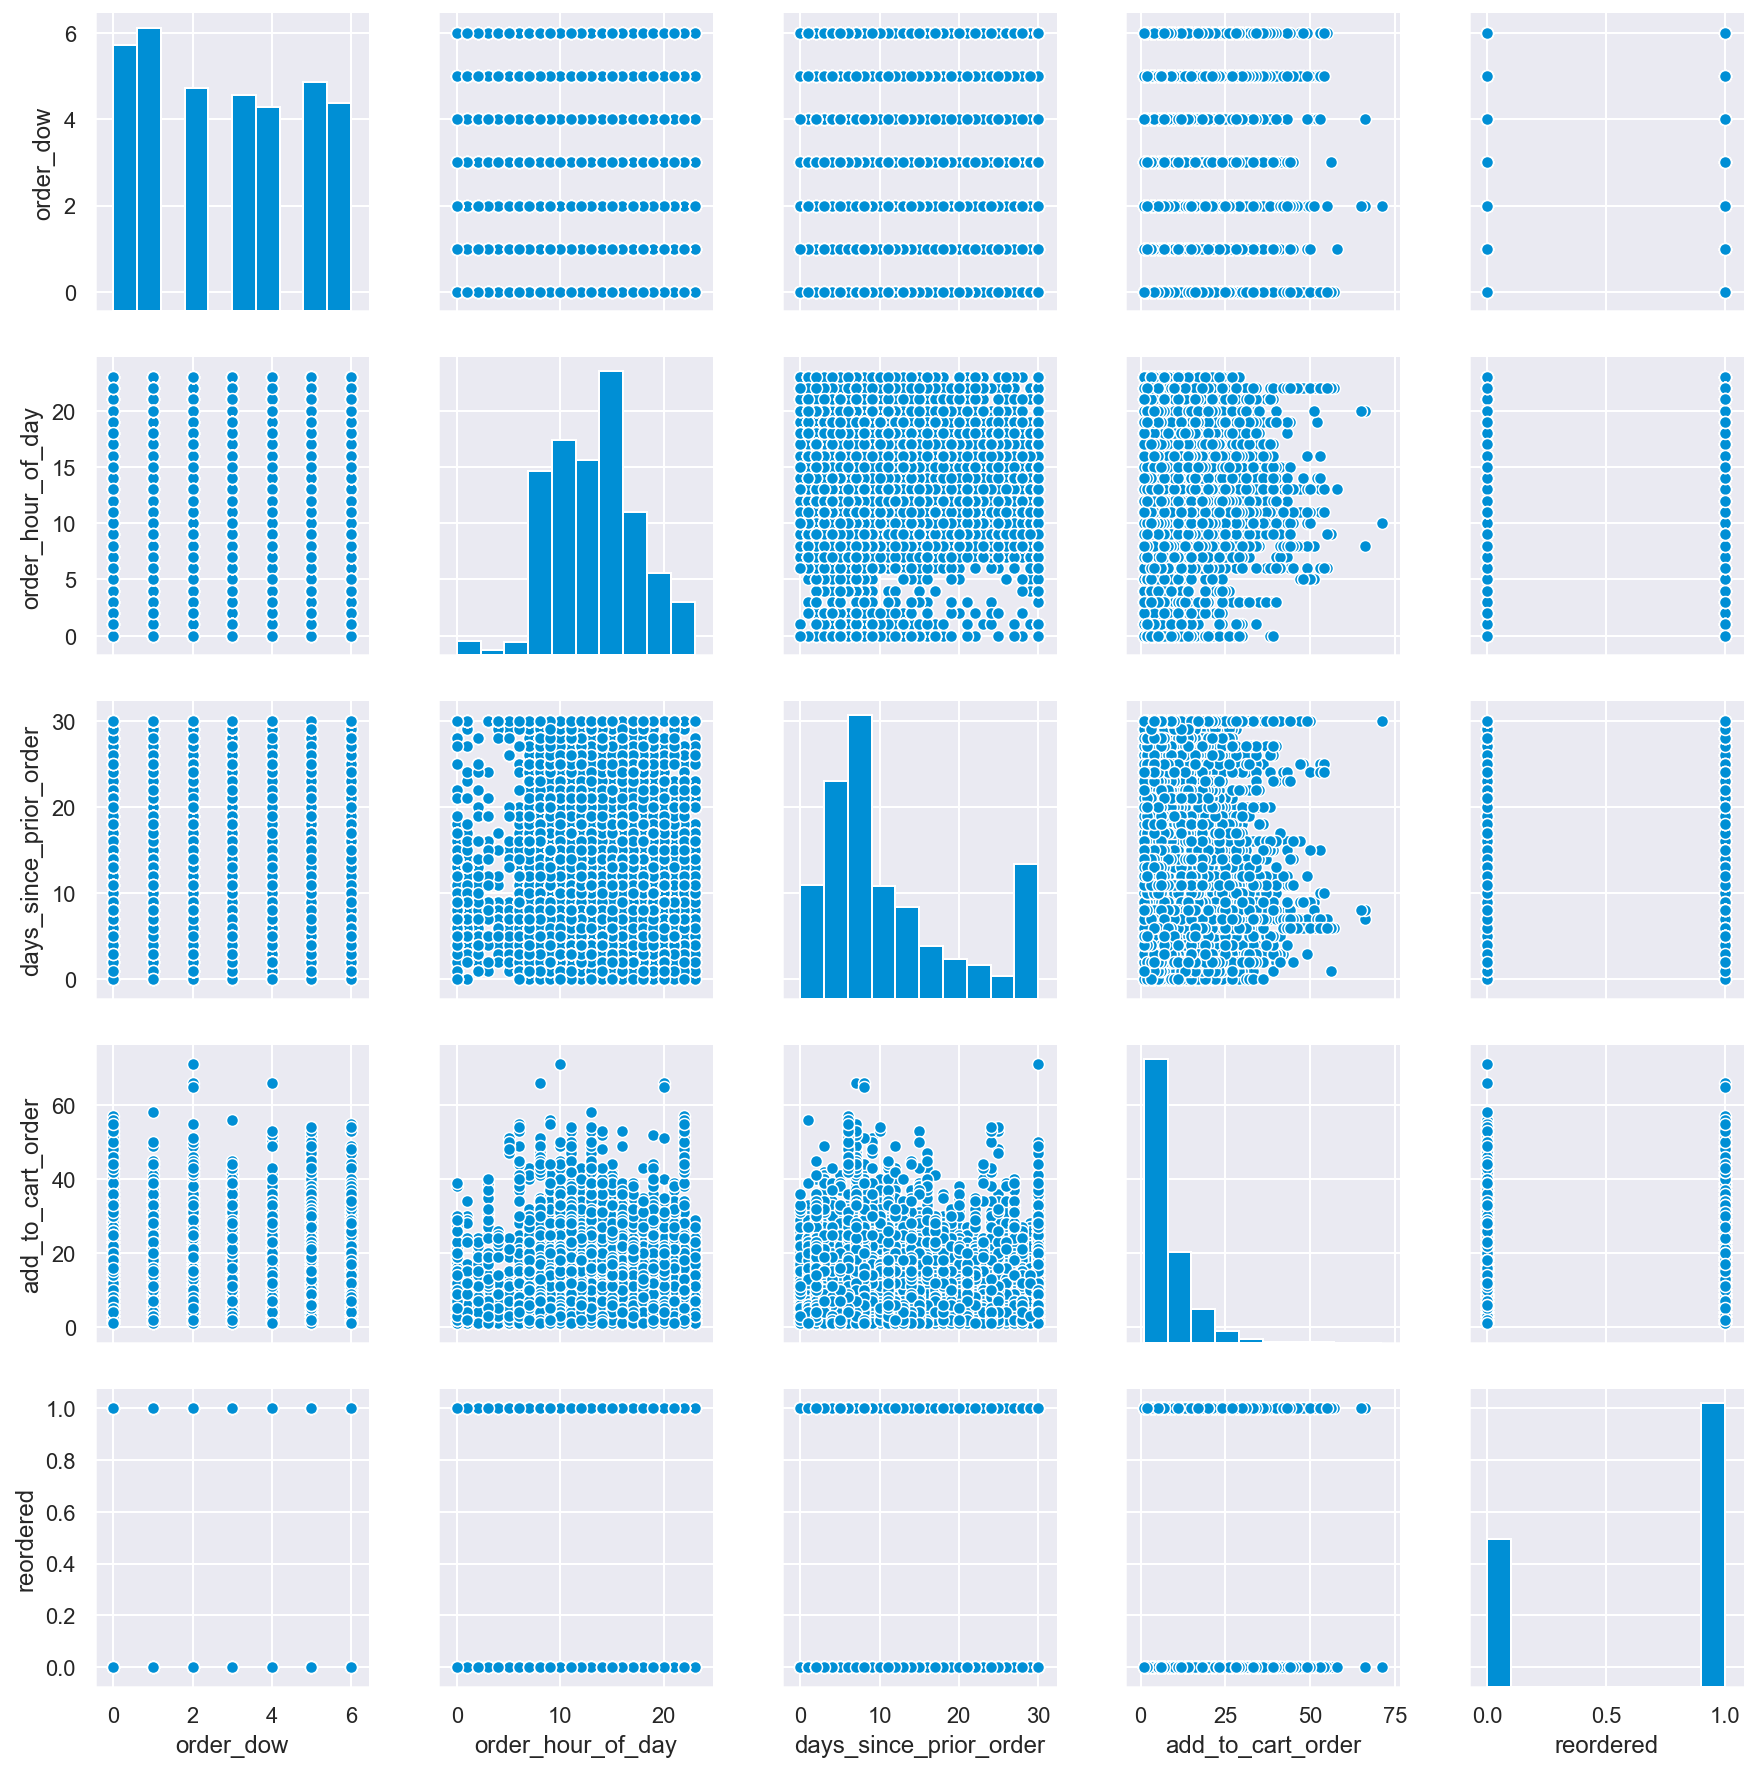

In [43]:
sns.pairplot(bevs_only[['order_dow', 'order_hour_of_day',
                        'days_since_prior_order', 'add_to_cart_order', 'reordered']])

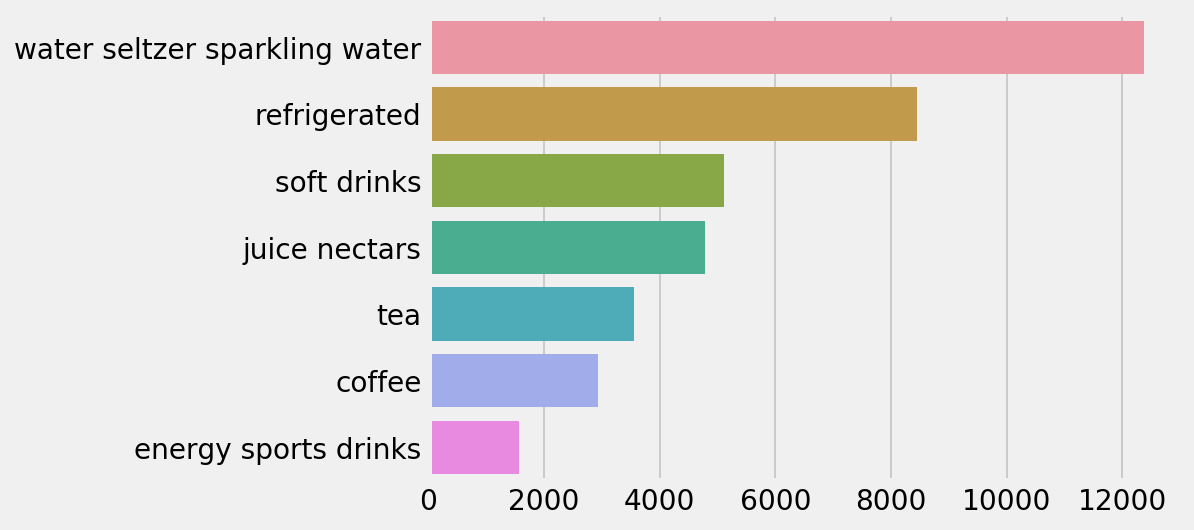

In [31]:
vc = bevs_only['aisle'].value_counts()

sns.barplot(y = vc.index, x = vc.values)
plt.show()

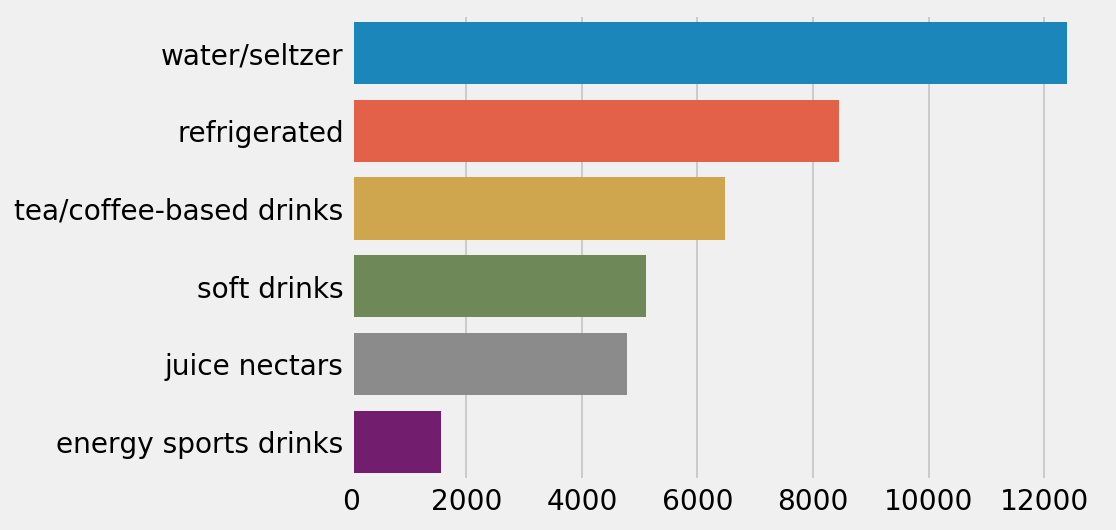

In [32]:
def aisle_rename(aisle):
    if aisle in ['tea', 'coffee']:
        return 'tea/coffee-based drinks'
    if aisle == 'water seltzer sparkling water':
        return 'water/seltzer'
    return aisle

bevs_only['aisle'] = bevs_only['aisle'].apply(aisle_rename)
vc = bevs_only['aisle'].value_counts()

sns.barplot(y = vc.index, x = vc.values)
plt.show()

In [33]:
bevs_only['product_name'].loc[bevs_only['aisle'] == 'water/seltzer'].value_counts()[:5]

sparkling water grapefruit         1113
spring water                        827
lime sparkling water                676
sparkling natural mineral water     645
sparkling lemon water               459
Name: product_name, dtype: int64

In [34]:
bevs_only['product_name'].loc[bevs_only['aisle'] == 'refrigerated'].value_counts()[:5]

100% raw coconut water                        547
original orange juice                         368
lemonade                                      312
original no pulp 100% florida orange juice    283
organic raw kombucha gingerade                276
Name: product_name, dtype: int64

In [35]:
bevs_only['product_name'].loc[bevs_only['aisle'] == 'tea/coffee-based drinks'].value_counts()[:5]

cold brew coffee                                   112
new orleans iced coffee                            105
premium unsweetened iced tea                        99
major dickason's blend ground coffee dark roast     86
cold-brew black coffee                              83
Name: product_name, dtype: int64

In [36]:
bevs_only['product_name'].loc[bevs_only['aisle'] == 'soft drinks'].value_counts()[:5]

soda                498
fridge pack cola    255
ginger ale          195
cola                173
coke classic        143
Name: product_name, dtype: int64

In [37]:
names_of_aisles = bevs_only['aisle'].unique()
names_of_aisles

array(['soft drinks', 'water/seltzer', 'refrigerated',
       'energy sports drinks', 'juice nectars', 'tea/coffee-based drinks'],
      dtype=object)

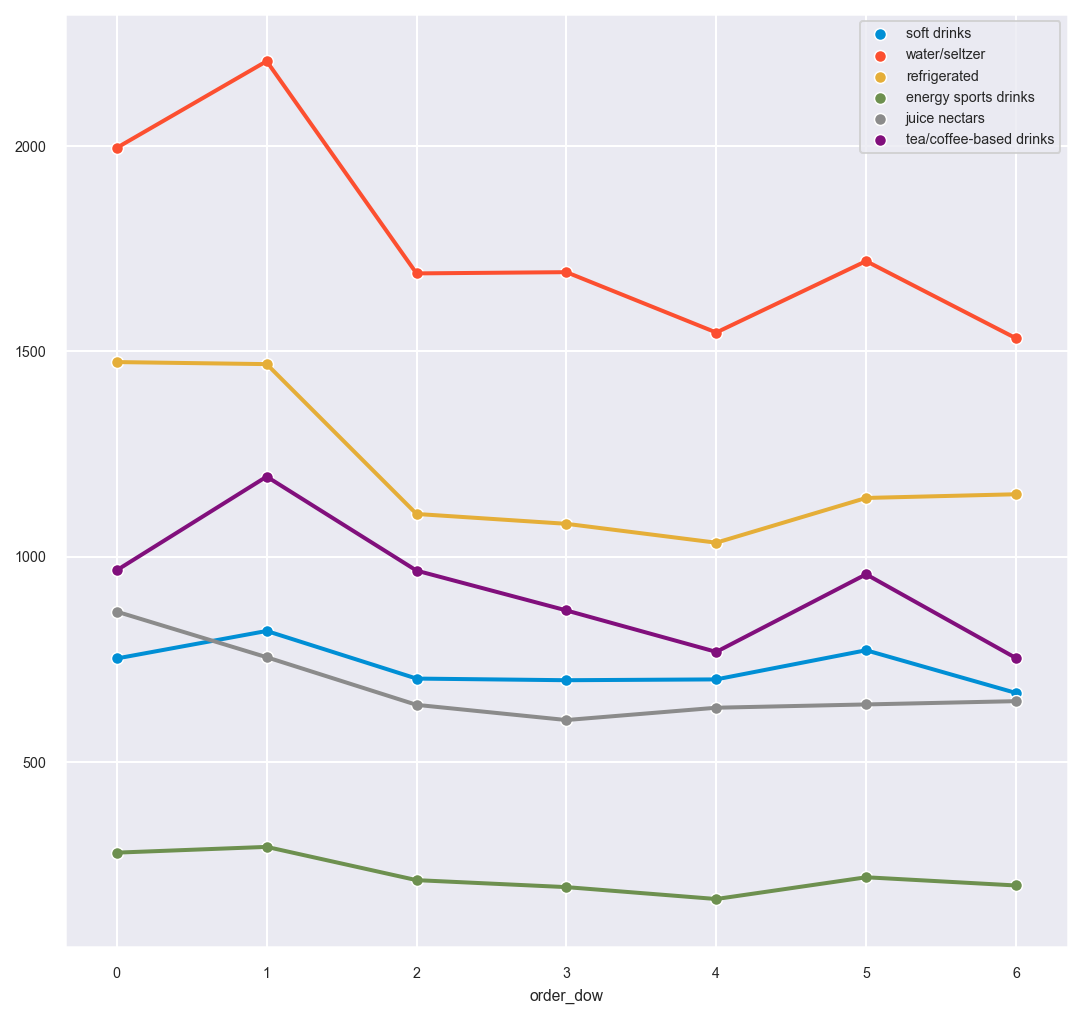

In [59]:
x = bevs_only.groupby(by = ['aisle', 'order_dow'])['counter'].count()
x = x.unstack()
pd.DataFrame(x)

plt.figure(figsize=(8, 8))
sns.set_style("darkgrid")
sns.set_context("notebook", rc={"lines.linewidth": 2}, font_scale=0.65)

for a in names_of_aisles:
    xs = x.xs(a)
    sns.lineplot(x = xs.index, y = xs.values)
    sns.scatterplot(x = xs.index, y = xs.values, label = a)


In [64]:
x = bevs_only.groupby(by = ['aisle', 'order_hour_of_day'])['counter'].count()
x = x.unstack()
pd.DataFrame(x)

order_hour_of_day,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
aisle,,,,,,,,,,,,,,,,,,,,,,,,
energy sports drinks,10,11,6,5,4,3,7,41,75,137,135,106,134,145,123,118,123,111,80,81,55,26,19,8
juice nectars,30,12,14,8,15,10,51,143,236,335,436,395,376,411,380,391,363,317,273,212,136,96,81,61
refrigerated,76,29,17,24,7,26,73,208,425,627,703,685,666,651,744,699,695,615,440,346,256,177,147,120
soft drinks,24,18,18,19,12,9,37,95,261,382,487,520,437,421,444,431,351,334,261,218,125,95,56,59
tea/coffee-based drinks,23,19,15,16,9,15,46,149,367,588,703,542,585,522,513,521,508,397,300,220,160,99,74,84
water/seltzer,67,39,23,17,17,28,117,301,615,1014,1268,1053,970,1061,925,945,980,870,665,524,344,241,181,119


In [49]:
x = bevs_only.groupby(by = ['aisle', 'order_hour_of_day'])['counter'].count()
x = x.unstack()
pd.DataFrame(x)

order_hour_of_day,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
aisle,,,,,,,,,,,,,,,,,,,,,,,,
energy sports drinks,10,11,6,5,4,3,7,41,75,137,135,106,134,145,123,118,123,111,80,81,55,26,19,8
juice nectars,30,12,14,8,15,10,51,143,236,335,436,395,376,411,380,391,363,317,273,212,136,96,81,61
refrigerated,76,29,17,24,7,26,73,208,425,627,703,685,666,651,744,699,695,615,440,346,256,177,147,120
soft drinks,24,18,18,19,12,9,37,95,261,382,487,520,437,421,444,431,351,334,261,218,125,95,56,59
tea/coffee-based drinks,23,19,15,16,9,15,46,149,367,588,703,542,585,522,513,521,508,397,300,220,160,99,74,84
water/seltzer,67,39,23,17,17,28,117,301,615,1014,1268,1053,970,1061,925,945,980,870,665,524,344,241,181,119


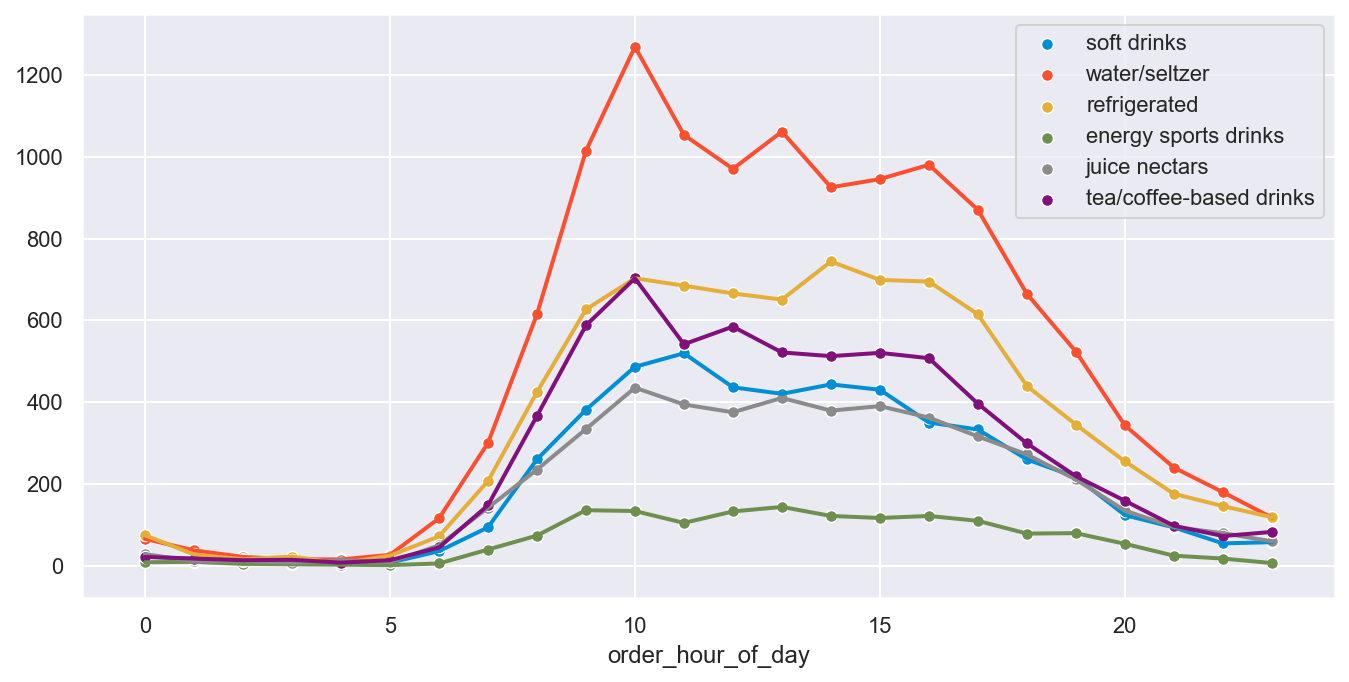

In [40]:
plt.figure(figsize=(10, 5))
sns.set_style("darkgrid")
sns.set_context("notebook", rc={"lines.linewidth": 2})

for a in names_of_aisles:
    xs = x.xs(a)
    sns.lineplot(x = xs.index, y = xs.values)
    sns.scatterplot(x = xs.index, y = xs.values, label = a)


In [79]:
y.columns

Index(['aisle', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], dtype='object', name='order_hour_of_day')

In [85]:
y = x.reset_index()

#y.drop(columns = 'order_hour_of_day')
y = y.reset_index()
#y = y.set_index('aisle')
y


order_hour_of_day,index,aisle,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,0,energy sports drinks,10,11,6,5,4,3,7,41,75,137,135,106,134,145,123,118,123,111,80,81,55,26,19,8
1,1,juice nectars,30,12,14,8,15,10,51,143,236,335,436,395,376,411,380,391,363,317,273,212,136,96,81,61
2,2,refrigerated,76,29,17,24,7,26,73,208,425,627,703,685,666,651,744,699,695,615,440,346,256,177,147,120
3,3,soft drinks,24,18,18,19,12,9,37,95,261,382,487,520,437,421,444,431,351,334,261,218,125,95,56,59
4,4,tea/coffee-based drinks,23,19,15,16,9,15,46,149,367,588,703,542,585,522,513,521,508,397,300,220,160,99,74,84
5,5,water/seltzer,67,39,23,17,17,28,117,301,615,1014,1268,1053,970,1061,925,945,980,870,665,524,344,241,181,119


In [ ]:
sns.lineplot(x = xs.index, y = xs.values, data = x, hue= 'aisle')
sns.scatterplot(x = xs.index, y = xs.values, data = x, hue = 'aisle')

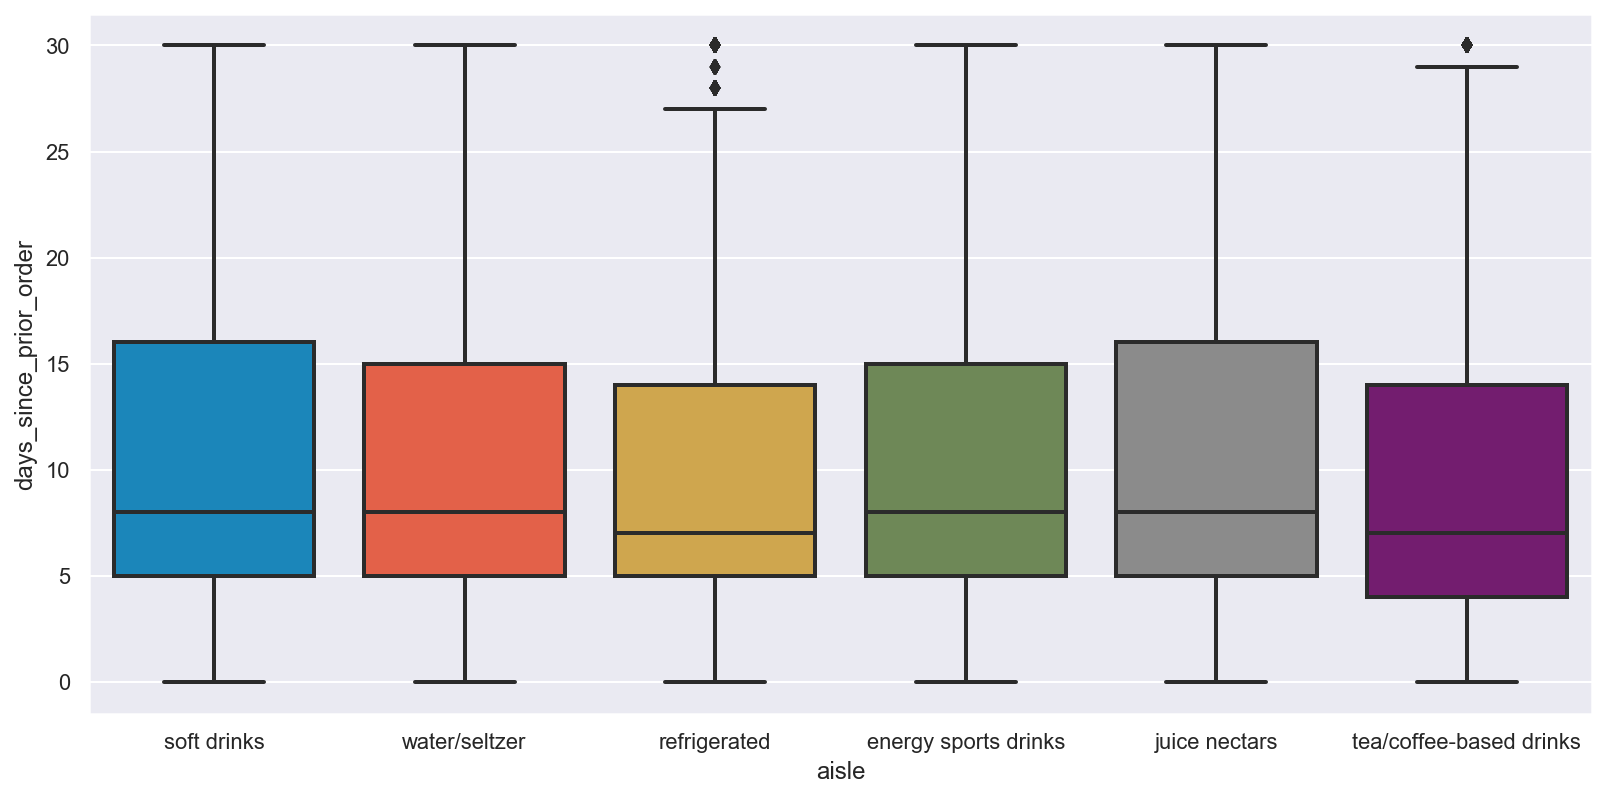

In [41]:
plt.figure(figsize = (12, 6))
sns.boxplot(x = 'aisle', y = 'days_since_prior_order', data = bevs_only)
plt.show()

In [57]:
bevs_only.columns

Index(['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'contains_bevs', 'contains_soft_drinks', 'product_id', 'add_to_cart_order', 'reordered', 'product_name', 'aisle_id', 'department_id', 'aisle', 'counter'], dtype='object')

In [58]:
bevs_only['order_dow']

31604    6
6272     6
5674     6
6988     6
38181    6
        ..
26409    4
11500    4
1371     6
14209    4
24393    4
Name: order_dow, Length: 38774, dtype: int64